<a href="https://colab.research.google.com/github/stefanagheorghita/CARN/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Tensor-Reloaded/Advanced-Topics-in-Neural-Networks-Template-2024.git


Cloning into 'Advanced-Topics-in-Neural-Networks-Template-2024'...
remote: Enumerating objects: 1705, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 1705 (delta 71), reused 143 (delta 60), pack-reused 1550 (from 1)
Receiving objects: 100% (1705/1705), 106.95 MiB | 26.83 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Updating files: 100% (1440/1440), done.


In [4]:
%cd Advanced-Topics-in-Neural-Networks-Template-2024/Lab04



/content/Advanced-Topics-in-Neural-Networks-Template-2024/Lab04


In [5]:
import os
import cv2

input_folder = 'Dataset'
output_folder = 'ConvertedDataset'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for location in os.listdir(input_folder):
    location_path = os.path.join(input_folder, location, "images")
    output_loc = os.path.join(output_folder, location, "images")

    if not os.path.exists(output_loc):
        os.makedirs(output_loc)

    for file in os.listdir(location_path):
        if file.endswith(".tif"):
            img_path = os.path.join(location_path, file)
            img = cv2.imread(img_path, -1)
            if img is not None:
                output_path = os.path.join(output_loc, file.replace(".tif", ".png"))
                cv2.imwrite(output_path, img)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 146MB/s]


Epoch 1/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Train Loss: 0.2276, Val Loss: 1.6378
Epoch 2/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Train Loss: 0.1247, Val Loss: 0.1182
Epoch 3/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Train Loss: 0.1143, Val Loss: 0.1178
Epoch 4/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Train Loss: 0.1144, Val Loss: 0.1076
Epoch 5/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Train Loss: 0.1116, Val Loss: 0.1130
Epoch 6/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Train Loss: 0.1151, Val Loss: 0.1190
Epoch 7/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Train Loss: 0.1105, Val Loss: 0.1285
Epoch 8/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Train Loss: 0.1075, Val Loss: 0.1090
Epoch 9/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Train Loss: 0.1064, Val Loss: 0.1278
Epoch 10/10


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Train Loss: 0.1075, Val Loss: 0.1337


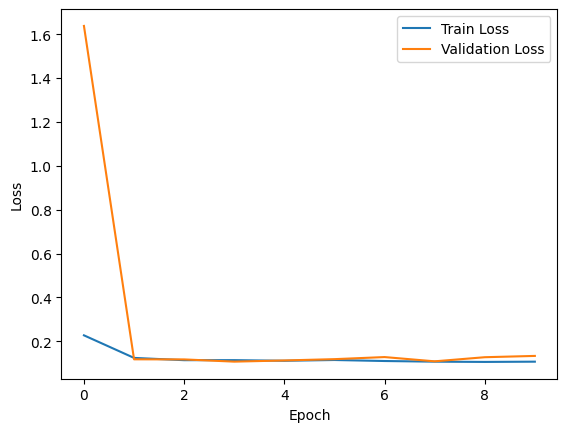

Testing: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

Test Loss: 0.1553


In [8]:
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
from torchvision.transforms import v2

import os
import re
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.io as io
import random
from datetime import datetime
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"


def calculate_time_skip(start_name, end_name):
    date_pattern = r"global_monthly_(\d{4})_(\d{2})"

    start_date_match = re.search(date_pattern, start_name)
    end_date_match = re.search(date_pattern, end_name)

    if start_date_match and end_date_match:
        start_year, start_month = int(start_date_match.group(1)), int(start_date_match.group(2))
        end_year, end_month = int(end_date_match.group(1)), int(end_date_match.group(2))

        start_date = datetime(start_year, start_month, 1)
        end_date = datetime(end_year, end_month, 1)
        time_skip = abs((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month))
        return time_skip
    else:
        raise ValueError("Invalid filename format for date extraction.")


def train(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for start_image, end_image, _ in tqdm(loader, desc="Training"):
        start_image, end_image = start_image.to(device), end_image.to(device)
        optimizer.zero_grad()
        output = model(start_image)
        loss = loss_fn(output, end_image)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)


def validate(model, loader, loss_func):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for start_image, end_image, _ in tqdm(loader, desc="Validation"):
            start_image, end_image = start_image.to(device), end_image.to(device)
            output = model(start_image)
            loss = loss_func(output, end_image)
            running_loss += loss.item()
    return running_loss / len(loader)


def run(model, train_loader, val_loader, optimizer, loss_func, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, loss_func)
        val_loss = validate(model, val_loader, loss_func)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return train_losses, val_losses


class HomeworkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []
        self.cache = {}

        for location in os.listdir(root_dir):
            location_path = os.path.join(root_dir, location, "images")
            if os.path.isdir(location_path):
                images = sorted(os.listdir(location_path))

                for i in range(len(images) - 1):
                    start_image_path = os.path.join(location_path, images[i])
                    end_image_path = os.path.join(location_path, images[i + 1])
                    time_skip = calculate_time_skip(images[i], images[i + 1])
                    self.pairs.append((start_image_path, end_image_path, time_skip))

    def __len__(self):
        return len(self.pairs)

    def _load_image(self, image_path):
        if image_path in self.cache:
            return self.cache[image_path]
        image = io.read_image(image_path).float() / 255.0
        self.cache[image_path] = image
        return image

    def __getitem__(self, idx):
        start_image_path, end_image_path, time_skip = self.pairs[idx]

        start_image = self._load_image(start_image_path)
        end_image = self._load_image(end_image_path)

        if self.transform:
            rotation_angle = random.randint(0, 360)
            start_image = TF.rotate(start_image, rotation_angle)
            end_image = TF.rotate(end_image, rotation_angle)
            start_image = self.transform(start_image)
            end_image = self.transform(end_image)

        return start_image, end_image, time_skip

def test(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for start_image, end_image, _ in tqdm(loader, desc="Testing"):
            start_image, end_image = start_image.to(device), end_image.to(device)
            output = model(start_image)
            loss = loss_fn(output, end_image)
            running_loss += loss.item()
    return running_loss / len(loader)



def show(epochs, train_loss, val_loss, path):
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(path)
    plt.show()


if __name__ == "__main__":
    dataset_path = 'ConvertedDataset'
    transform = v2.Compose([
        v2.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    n_epochs = 10
    full_dataset = HomeworkDataset(root_dir=dataset_path, transform=transform)

    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=3
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.MSELoss()


    train_loss, val_loss = run(model, train_loader, val_loader, optimizer, loss_func, n_epochs)
    show(n_epochs, train_loss, val_loss, "plot.png")

    test_loss = test(model, test_loader, loss_func)
    print(f"Test Loss: {test_loss:.4f}")

In [7]:
!pip install segmentation_models_pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=118953d3a1b7aae8a3296fc2b5b7714c54362c2fafc06a4aee979437c17f9ea6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0076fb5f3c4c1006b81eb19f27a4b69ad25f26c87ffc4df04011336c4838793a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch